# Random Forests (Rastgele Ormanlar)

Temeli birden çok karar ağacın ürettiği tahminlerin bir araya getirilerek değerlendirilmesine dayanır. Birden fazla karar ağacının belirli bir sınıflandırma veya regresyon problemi için tahminlerinin bir araya getirilmesiyle nihai karara varılması yöntemidir.

- Bagging (bootstrap aggregation) (Breiman, 1996) ile Random Subspace (Ho, 1998) yöntemlerinin birleştirilmesi ile oluşmuştur.

- Ağaçlar için **gözlemler (bagging-bootstrap aggregation) bootstrap rastgele örneklem yöntemi ile, değişkenler random subspace yöntemi ile seçilir.** Örneğin 500 tane ağaç varsa, bunlar veri setinin içerisine yerine koymalı yani bootstrap örnekleme yöntemi tekrar tekrar örneklem seçilerek ağaçlar oluşturulur ve bu ağaçların üzerinde modeller kurullur. Değişkenler seçiminde ise her bir ağaç içerisinde rastgele alt küme seçimi üzerinden değişkenler göz önünde bulundurulur. (gözlem seçimlerinde rastgelelik ve değişken seçimlerinde rastgelelik)

- Karar ağacının her bir düğümünde en iyi dallara ayırıcı (bilgi kazancı) değişken tüm değişkenler arasından rastgele seçilen daha az sayıdaki değişken arasından seçilir. Örneği 100 tane değişken var. Bunun içerisinden 20 tane değişkeni rastgele seçer. Bu seçmiş olduğu 20 tane değişkene bakıp bunlara göre dallanma işlemlerine karar verir. Bu şekilde aslında değişken seçimi ve gözlem seçimi ile rassallığı korumuş olur, genellenebilirliği korumaya çalışır. **Random Forest, *random* ismini buradan almaktadır.**

- Ağaç oluşturmada veri setinin 2/3'ü kullanılır. Dışarıda kalan veri ağaçların performans değerlendirmesi ve değişken öneminin belirlenmesi için kullanılır.

- Her düğüm noktasında rastgele değişken seçimi yapılır. (regresyonda p/3, sınıflandırmada karekök p)

Bagging ile Boosting yöntemleri arasındaki fark nedir?

Bagging yöntemlerinde ağaçların birbirlerine bağımlılıkları yoktur. Boosting yöntemlerinde ise ağaçlar artıklar üzerine kurulur. Dolayısıyl ağaçların birbirlerine bağımlılıkları vardır. 

## Random Forest Kodlama Kısmı

In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve

warnings.simplefilter(action='ignore', category=Warning)

In [3]:
df = pd.read_csv("datasets/diabetes.csv")

In [4]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

### Random Forest

In [11]:
rf_model = RandomForestClassifier(random_state=17)

In [12]:
cv_results = cross_validate(rf_model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])

In [13]:
print("Accuracy: ", cv_results["test_accuracy"].mean())
print("F1: ", cv_results["test_f1"].mean())
print("ROC-AUC: ", cv_results["test_roc_auc"].mean())

Accuracy:  0.753896103896104
F1:  0.6190701534636385
ROC-AUC:  0.8233960113960114


Modelimizde hiçbir parametre değiştirmek işlemi yapmadan düz kullandığımızda aldığımız sonuçlar yukarıdaki gibidir. Şimdi modelimize hiperparametre optimizasyonu yapalım ve ondan sonra sonuçlarımız nasıl etkilenmiş karşılaştıralım.

In [14]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 17,
 'verbose': 0,
 'warm_start': False}

Buradaki max_depth, max_features ve min_samples_split bizim için önemli. n_estimators, fit edilecek bağımsız ağaç sayısını ifade etmektedir. Buradaki modelden en iyi verimi alabilmek için bu hiperparametrelere hangi değerleri girmeliyim? Bu noktada GridSearch yapmamız gerekiyor. Bunun için bu değişkenlerde gezecek değerlerin bir sözlük içerisinde tanıtmamız gerekiyor.

In [15]:
rf_params = {"max_depth": [5, 8, None],
            "max_features": [3, 5, 7, "auto"],
            "min_samples_split": [2, 5, 8, 15, 20],
            "n_estimators": [100, 200, 500]}

Hiperparametre optimizasyonu yaptığımız halde öncekinden daha yüksek hata aldık?

Pratikte hiperparametre optimizasyonu sonrası elde edilen hata değerinin daha düşük olmasını bekleriz. Düşük olmamasının sebepleri; rastgelelikle ilgili olabilir, ön tanımlı argümanların arama setinde bulunmaması olabilir. Dolayısıyla yukarıda değerleri tuttuğumuz dict yapısında, her bir hiperparatrenin ön tanımlı değerleri de değerler arasında bulundurulmalıdır.

In [16]:
rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  8.2min finished


In [18]:
rf_best_grid.best_params_

{'max_depth': None,
 'max_features': 5,
 'min_samples_split': 8,
 'n_estimators': 500}

Modelimiz için en iyi parametreler yukarıdaki gibidir. Şimdi bu parametreleri modelimizin parametrelerine set edelim.

In [20]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X, y)

Final modelimizi oluşturduk. Şimdi final modelimiz üzerinden cross validate yapalım ve hata sonuçlarımızı değerlendirelim.

In [22]:
cv_results = cross_validate(rf_final, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])

In [23]:
print("Accuracy: ", cv_results["test_accuracy"].mean())
print("F1: ", cv_results["test_f1"].mean())
print("ROC-AUC: ", cv_results["test_roc_auc"].mean())

Accuracy:  0.766848940533151
F1:  0.6447777811143756
ROC-AUC:  0.8271054131054132


Metriklerimiz artış göstermekle beraber hemen hemen yakın sonuçlar göstermiştir. Daha iyi yaklaşabilmek için feauture importances ve learning curve fonksiyonlarını kullanarak bunlara da bir göz atabiliriz.

In [24]:
def plot_importance(model, features, num=len(X), save=False):
    # featureların katkı değerleri ve bu featureların isimlerinin tutulduğu bir df oluşturulması
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    # oluşturduğumuz df'nin bir sütun grafik ile görselleştirilmesi
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x='Value', y='Feature', data=feature_imp.sort_values(by='Value', ascending=False)[0:num]) # num parametresi df içerisinden kaç tane değişkenin grrafikte yer alacağını belirleyen parametre
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    
    if save: # eğer save parametresi true olarak girilirse, oluşturulan grafik aşağıdaki isim ile dosyaya kaydedilir
        plt.savefig('importances.png')

In [25]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
    model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)
    
    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)
    
    plt.plot(param_range, mean_train_score,
            label="Training Score", color="b")
    
    plt.plot(param_range, mean_test_score,
            label="Test (Validation) Score", color="g")
    
    plt.title(f"Test (Validation) Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc="best")
    plt.show()

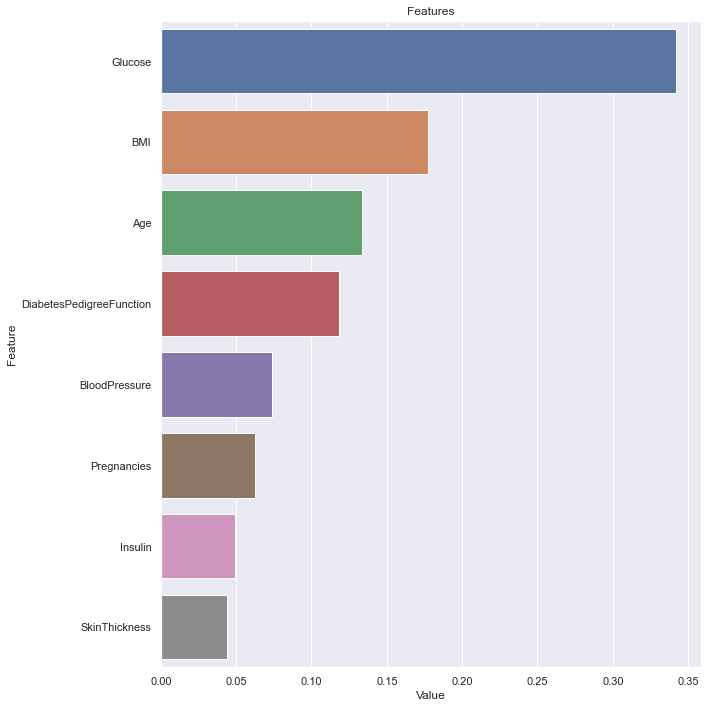

In [26]:
plot_importance(rf_final, X)

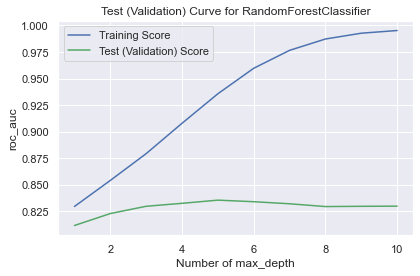

In [27]:
val_curve_params(rf_final, X, y, "max_depth", range(1, 11))